In [1]:
import sys
sys.path.insert(1, '../')
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from concentration import logistic, standard_logistic_interval, pp_logistic_interval
from tqdm import tqdm
import pdb

from logistic_utils import get_data, plot_data, get_tree, make_plots, acs_filter

/Users/angelopoulos/miniconda3/envs/mai/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Interval Constructions

In [2]:
def trial(X, Y, Yhat, true, n, alpha):
    X_labeled, X_unlabeled, Y_labeled, Y_unlabeled, Yhat_labeled, Yhat_unlabeled = train_test_split(X, Y, Yhat, train_size=n)

    imputed_interval = standard_logistic_interval(X, Yhat, alpha)

    classical_interval = standard_logistic_interval(X_labeled, Y_labeled, alpha)

    pp_interval = pp_logistic_interval(X_labeled, X_unlabeled, Y_labeled, Yhat_labeled, Yhat_unlabeled, alpha)

    return imputed_interval, classical_interval, pp_interval

## Monte Carlo Trials of Experiment

/Users/angelopoulos/Code/working/prediction-powered-inference/census/logistic_utils.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'PRIVCOV'] = 1-(df.loc[:,'PRIVCOV']-1)
/Users/angelopoulos/Code/working/prediction-powered-inference/census/logistic_utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['', '<20K', '20K-40K','40K-60K','60K-80K','80K-100K', '>100K'])


True logistic regression coefficients: [2.09549568e-05 9.81238724e-11]


100%|███████████████████████████████████████████| 10/10 [16:21<00:00, 98.19s/it]


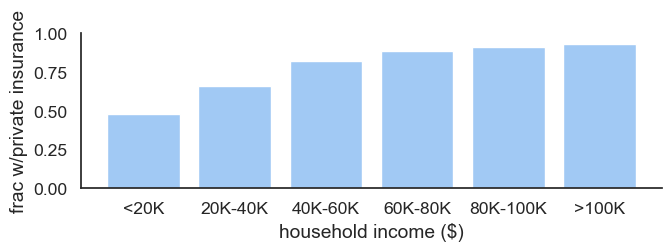

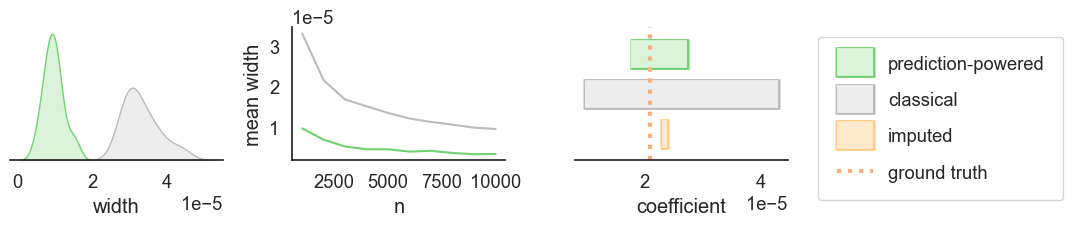

In [3]:
# Train tree on 2017 data
np.random.seed(0) # Fix seed for tree
tree = get_tree()
np.random.seed(0) # Fix seed for evaluation

# Evaluate tree and plot data in 2018
features_2018, privcov_2018 = get_data(year=2018, features=['AGEP','SCHL','MAR','RELP','DIS','PINCP','ESP','CIT','MIG','MIL','ANC','NATIVITY','DEAR','DEYE','DREM','SEX','RAC1P'], outcome='PRIVCOV', acs_filter=acs_filter)
predicted_privcov_2018 = tree.predict(xgb.DMatrix(features_2018.to_numpy()))
pincp_2018 = features_2018['PINCP']
plot_data(pincp_2018, privcov_2018)

# Collect logistic features
X = np.stack([pincp_2018, np.ones_like(pincp_2018)], axis=1)
true = logistic(X, privcov_2018)

print(f"True logistic regression coefficients: {true}")

try:
    df = pd.read_pickle('./.cache/logistic-results.pkl')
except:
    N = features_2018.shape[0]
    num_n = 10
    ns = np.linspace(1000, 10000, num_n).astype(int)
    num_trials = 10
    alpha = 0.05

    # Store results
    columns = ["lb","ub","covered","estimator","n"]

    results = []
    for j in tqdm(range(ns.shape[0])):
        for i in range(num_trials):
            n = ns[j]
            ii, ci, ppi = trial(X, privcov_2018.to_numpy(), predicted_privcov_2018, true, n, alpha)
            temp_df = pd.DataFrame(np.zeros((3,len(columns))), columns=columns)
            temp_df.loc[0] = ii[0][0], ii[1][0], (ii[0][0] <= true[0]) & (true[0] <= ii[1][0]), "imputed", n
            temp_df.loc[1] = ci[0][0], ci[1][0], (ci[0][0] <= true[0]) & (true[0] <= ci[1][0]), "classical", n
            temp_df.loc[2] = ppi[0][0], ppi[1][0], (ppi[0][0] <= true[0]) & (true[0] <= ppi[1][0]), "prediction-powered", n
            results += [temp_df]
    df = pd.concat(results)
    df["width"] = df["ub"] - df["lb"]
    df.to_pickle('./.cache/logistic-results.pkl')

make_plots(df, true)